In [1]:
import numpy as np

values = np.load('best_Ts.npy', allow_pickle=True)
values.shape

(30, 4, 4)

In [2]:
values[0]

array([[ 2.54343434, 22.30236435,  0.7646758 ,  0.45814604],
       [ 2.6030303 , 22.8068924 ,  0.76855129,  0.45723328],
       [ 2.48383838, 21.72849464,  0.76018367,  0.4570553 ],
       [ 2.72222222, 23.44671631,  0.7734729 ,  0.45700279]])

In [3]:
values[1]

array([[ 3.67575758, 17.30495644,  0.59299096,  0.47899669],
       [ 3.61616162, 17.86412811,  0.60048668,  0.47851411],
       [ 3.1989899 , 21.7497921 ,  0.6335347 ,  0.47691226],
       [ 3.55656566, 18.44109344,  0.60760334,  0.47653684]])

In [4]:
values[2]

array([[ 2.9010101 , 15.24044895,  0.68798668,  0.6073817 ],
       [ 2.96060606, 14.70271683,  0.67799896,  0.60640877],
       [ 2.84141414, 15.80789185,  0.6976413 ,  0.60600698],
       [ 3.02020202, 14.19363499,  0.66783474,  0.60413688]])

In [5]:
values[3]

array([[4.92727273, 9.48664856, 0.63242307, 0.53154755],
       [4.86767677, 9.62754154, 0.63982052, 0.530379  ],
       [4.98686869, 9.35270214, 0.62521454, 0.53005314],
       [0.1       , 7.38644981, 0.33041215, 0.52979183]])

In [6]:
values[4]

array([[ 2.24545455, 17.96892357,  0.69103399,  0.51204497],
       [ 2.18585859, 17.38010216,  0.67708455,  0.50746906],
       [ 2.30505051, 18.60709381,  0.70462269,  0.50736278],
       [ 2.12626263, 16.83667755,  0.66194348,  0.50104475]])

In [7]:
values[5]

array([[ 1.41111111, 13.6773634 ,  0.38522319,  0.43239644],
       [ 1.35151515, 13.48497963,  0.36738005,  0.43015039],
       [ 1.47070707, 13.88014793,  0.40342677,  0.43009591],
       [ 1.29191919, 13.30622673,  0.35038582,  0.42388043]])

In [8]:
values[6]

array([[ 2.84141414, 19.05081367,  0.62552562,  0.52283937],
       [ 2.78181818, 18.54976845,  0.61450738,  0.52200991],
       [ 2.9010101 , 19.56665039,  0.63556728,  0.52009356],
       [ 2.96060606, 20.08760452,  0.64438801,  0.51718509]])

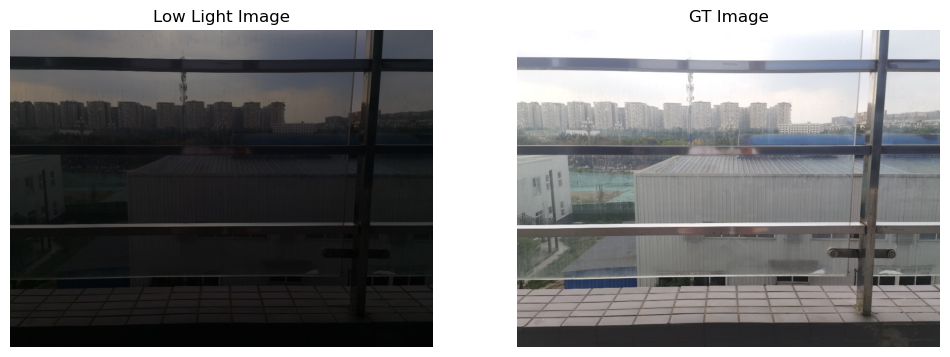

In [9]:
# idx 3이 좀 문제가 있나.. 이미지 확인
import os
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt

file_path = Path('/data/soom/LSRW/eval/Huawei')
img_labels = sorted(os.listdir(file_path / 'low'))

lq_img = Image.open(file_path / 'low' / img_labels[3])
hq_img = Image.open(file_path / 'high' / img_labels[3])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display low quality image
axes[0].imshow(lq_img)
axes[0].set_title('Low Light Image')
axes[0].axis('off')

# Display high quality image
axes[1].imshow(hq_img)
axes[1].set_title('GT Image')
axes[1].axis('off')

plt.show()

In [10]:
import numpy as np
import torch
from network.conv_node import NODE
from misc import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NODE(device, (3, 256, 256), 32, augment_dim=0, time_dependent=True, adjoint=True)
model.eval()
model.to(device)
model.load_state_dict(torch.load(f'pth/universal.pth', weights_only=True), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['odefunc.norm.weight', 'odefunc.norm.bias', 'odefunc.condition.conv.0.weight', 'odefunc.condition.conv.0.bias', 'odefunc.condition.conv.2.weight', 'odefunc.condition.conv.2.bias', 'odefunc.condition.conv.4.weight', 'odefunc.condition.conv.4.bias', 'odefunc.cond_brightness.0.weight', 'odefunc.cond_brightness.2.weight', 'odeblock.odefunc.norm.weight', 'odeblock.odefunc.norm.bias', 'odeblock.odefunc.condition.conv.0.weight', 'odeblock.odefunc.condition.conv.0.bias', 'odeblock.odefunc.condition.conv.2.weight', 'odeblock.odefunc.condition.conv.2.bias', 'odeblock.odefunc.condition.conv.4.weight', 'odeblock.odefunc.condition.conv.4.bias', 'odeblock.odefunc.cond_brightness.0.weight', 'odeblock.odefunc.cond_brightness.2.weight'])

In [17]:
from torchvision.transforms.functional import to_pil_image
from torchmetrics.multimodal import CLIPImageQualityAssessment

def image_tensor(image_path, size=None):
    img = Image.open(image_path)
    
    if size != None:
        img = img.resize(size)

    img = (np.asarray(img)/255.0)
    img = torch.from_numpy(img).float()
    img = img.permute(2,0,1).unsqueeze(0)
    return img

lq_img = image_tensor(file_path / 'low' / img_labels[3], (256, 256)).to(device)
hq_img = image_tensor(file_path / 'high' / img_labels[3], (256, 256)).to(device)



prompts = (('good exposure', 'bad exposure'), ('good exposure', 'under or over exposure'))
clip_iqa = CLIPImageQualityAssessment(prompts=prompts).to(device)

def calculate_clip_score(pred):
    score = clip_iqa(pred.unsqueeze(0))
    
    return score['user_defined_0'].item(), score['user_defined_1'].item()

4it [00:16,  4.14s/it]


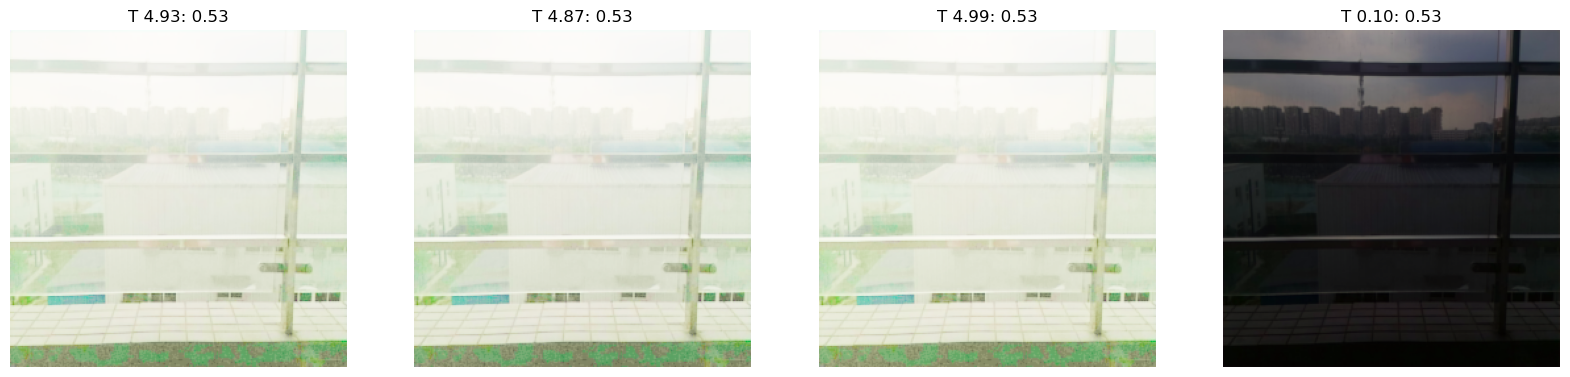

In [18]:
T_values = values[3, :, 0]
fig = plt.figure(figsize=(20, 10))

for i, T in tqdm(enumerate(T_values)):
    with torch.no_grad():
        integration_time = torch.tensor([0, T]).float().cuda()
        pred = model(lq_img, integration_time, inference=True)['output'][0]
        _clip_score, _ = calculate_clip_score(pred)
        pred_img = to_pil_image(pred.cpu())
        ax = plt.subplot(1, len(T_values), i+1)
        plt.imshow(pred_img)
        plt.title(f'T {T:.2f}: {_clip_score:.2f}')
        plt.axis('off')
plt.show()

6it [00:27,  4.62s/it]


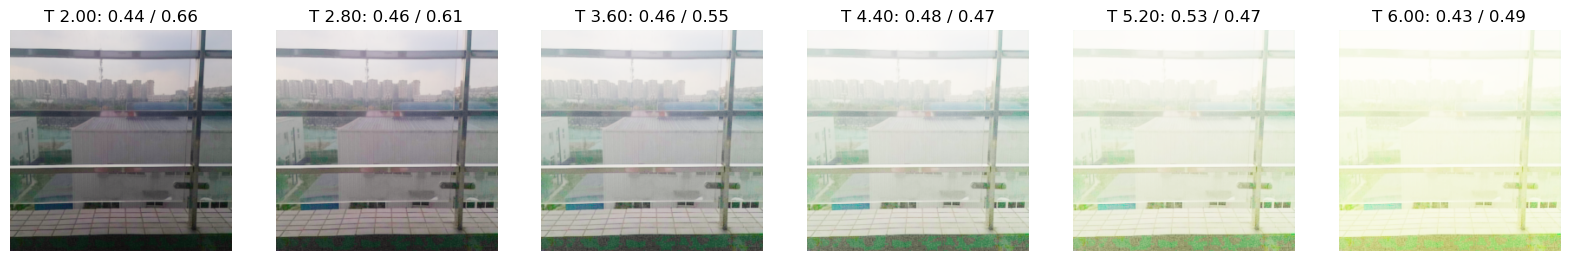

In [19]:
T_values = np.linspace(2.0, 6.0, 6)
fig = plt.figure(figsize=(20, 10))

for i, T in tqdm(enumerate(T_values)):
    with torch.no_grad():
        integration_time = torch.tensor([0, T]).float().cuda()
        pred = model(lq_img, integration_time, inference=True)['output'][0]
        _clip_score0, _clip_score1 = calculate_clip_score(pred)
        pred_img = to_pil_image(pred.cpu())
        ax = plt.subplot(1, len(T_values), i+1)
        plt.imshow(pred_img)
        plt.title(f'T {T:.2f}: {_clip_score0:.2f} / {_clip_score1:.2f}')
        plt.axis('off')
plt.show()